In [37]:
import pandas as pd
from pathlib import Path

LABEL_MAP = {
    0: "Benign",
    1: "DDoS",
    2: "DoS",
    3: "Reconnaissance",
    4: "MITM_ArpSpoofing",
    5: "DNS_Spoofing",
}


class IncrementalTimelineBuilder:
    def __init__(self, parquet_dir, label_map):
        self.parquet_dir = Path(parquet_dir)
        self.label_map = label_map
        self.seen_classes = set()
        self.rows = []

    # def infer_drift_type(self, new_classes):
    #     if not new_classes:
    #         return "Gradual"
    #     if len(self.seen_classes) == 0:
    #         return "–"
    #     return "Sudden"   # bạn có thể custom logic

    def build(self):
        parquet_files = [self.parquet_dir / f"session{index}.parquet" for index in range(0,3)]

        for step_idx, file in enumerate(parquet_files, start=0):
            df = pd.read_parquet(file)

            # class id
            class_ids = set(df["Label"].unique())

            # map → class name
            classes = {self.label_map[int(c)] for c in class_ids}
            if step_idx ==0:
                new_classes = []
            else:
                new_classes = classes - self.seen_classes

            self.rows.append([
                f"Case {step_idx}",
                len(df),
                "{" + ", ".join(sorted(classes)) + "}",
                "{" + ", ".join(sorted(new_classes)) + "}" if len(new_classes)> 0 else "{}"
            ])

            self.seen_classes |= classes

        return pd.DataFrame(
            self.rows,
            columns=[
                "Increment Step",
                "#Samples",
                "Classes Seen",
                "New Classes"
            ]
        )



In [38]:

dir = r"C:\Users\hoang\Documents\Dataset_KLTN\ciciot2023_extracted\merge-processed\merge1.4_3-4-5\case-from-3-incre-4class-incre-6class"

builder = IncrementalTimelineBuilder(dir, label_map= LABEL_MAP)
timeline_df = builder.build()

print(timeline_df)

  Increment Step  #Samples                                       Classes Seen  \
0         Case 0   1200000                                {Benign, DDoS, DoS}   
1         Case 1    459999                {Benign, DDoS, DoS, Reconnaissance}   
2         Case 2    520000  {Benign, DDoS, DNS_Spoofing, DoS, MITM_ArpSpoo...   

                        New Classes  
0                                {}  
1                  {Reconnaissance}  
2  {DNS_Spoofing, MITM_ArpSpoofing}  


In [17]:

def latex_escape(s):
    if not isinstance(s, str):
        s = str(s)
    return (
        s.replace("\\", r"\textbackslash ")
         .replace("_", r"\_")
         .replace("{", r"\{")
         .replace("}", r"\}")
         .replace("%", r"\%")
         .replace("&", r"\&")
         .replace("#", r"\#")
         .replace("$", r"\$")
    )
    
df_latex = timeline_df.applymap(latex_escape)

latex_table = df_latex.to_latex(
    index=False,
    escape=False,     # 🔥 quan trọng
    column_format="lrrll"
)

with open("incremental_timeline.tex", "w") as f:
    f.write(latex_table)


C:\Users\hoang\AppData\Local\Temp\ipykernel_17480\4038794956.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_latex = timeline_df.applymap(latex_escape)


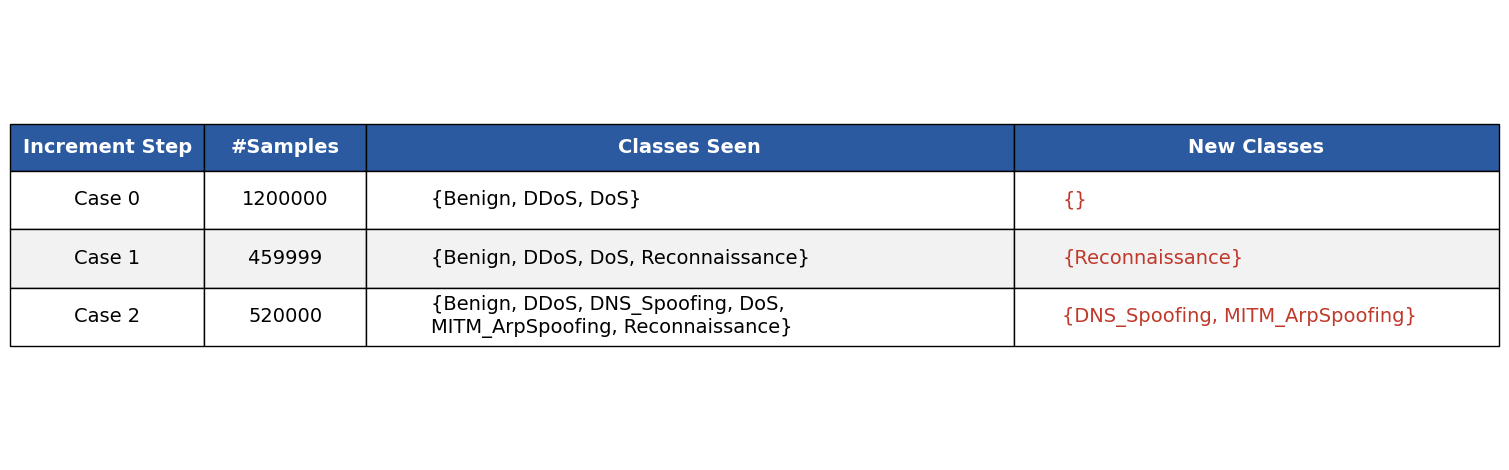

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

def plot_incremental_table_slide(df, save_path=None):
    def wrap_text(s, width=40):
        return "\n".join(textwrap.wrap(str(s), width))

    # Wrap only class columns
    df_plot = df.copy()
    for col in ["Classes Seen", "New Classes"]:
        df_plot[col] = df_plot[col].apply(lambda x: wrap_text(x, 38))

    # Column width heuristic
    col_ratios = np.array([1.2, 1.0, 4.0, 3.0])
    col_widths = col_ratios / col_ratios.sum()

    fig_height = 1.0 * len(df_plot) + 1.8
    fig, ax = plt.subplots(figsize=(15, fig_height))
    ax.axis("off")

    table = ax.table(
        cellText=df_plot.values,
        colLabels=df_plot.columns,
        colWidths=col_widths,
        cellLoc="center",
        loc="center"
    )

    table.auto_set_font_size(False)
    table.set_fontsize(14)
    table.scale(1.1, 2.3)

    # Header
    for c in range(len(df_plot.columns)):
        cell = table[(0, c)]
        cell.set_facecolor("#2C5AA0")
        cell.set_text_props(color="white", weight="bold")

    cls_seen_col = df_plot.columns.get_loc("Classes Seen")
    new_cls_col = df_plot.columns.get_loc("New Classes")

    # Body styling
    for r in range(1, len(df_plot) + 1):
        bg = "#F2F2F2" if r % 2 == 0 else "white"

        max_lines = max(
            table[(r, cls_seen_col)].get_text().get_text().count("\n"),
            table[(r, new_cls_col)].get_text().get_text().count("\n"),
            1
        )

        for c in range(len(df_plot.columns)):
            cell = table[(r, c)]
            cell.set_facecolor(bg)
            cell.set_height(0.09 + max_lines * 0.04)

            if c in (cls_seen_col, new_cls_col):
                txt = cell.get_text()
                txt.set_ha("left")
                txt.set_va("center")
                txt.set_x(0.03)

        if df_plot.iloc[r - 1]["New Classes"] != "∅":
            table[(r, new_cls_col)].set_text_props(color="#C0392B") # weight="bold"

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

plot_incremental_table_slide(timeline_df, "fig.png")

['Benign', 'DDoS', 'DoS', 'Reconnaissance', 'MITM_ArpSpoofing', 'DNS_Spoofing']


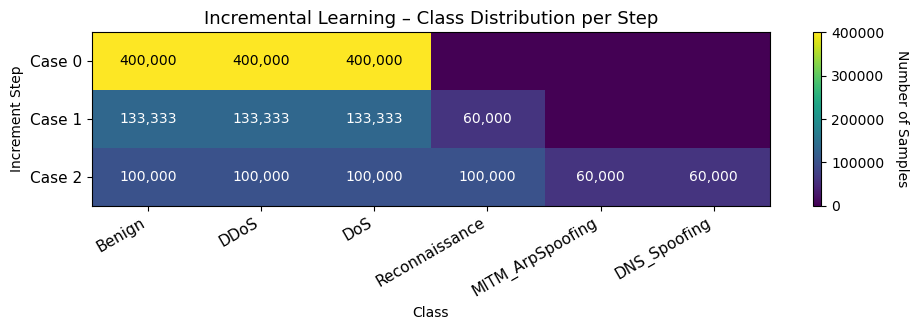

In [15]:
LABEL_MAP = {
    0: "Benign",
    1: "DDoS",
    2: "DoS",
    3: "Reconnaissance",
    4: "MITM_ArpSpoofing",
    5: "DNS_Spoofing"
}

cols = [LABEL_MAP[col] for col in LABEL_MAP]
print(cols)

import pandas as pd
from pathlib import Path

def build_step_class_matrix(parquet_files):
    rows = []
    all_classes = set()

    for step_idx, p in enumerate(parquet_files, start=0):
        df = pd.read_parquet(p)

        counts = (
            df["Label"]
            .value_counts()
            .rename(index=LABEL_MAP)
            .to_dict()
        )

        all_classes |= set(counts.keys())

        rows.append({
            "Step": f"Case {step_idx}",
            **counts
        })

    matrix = pd.DataFrame(rows).fillna(0).set_index("Step")
    matrix = matrix[cols]  # giữ thứ tự class ổn định

    return matrix.astype(int)

import matplotlib.pyplot as plt
import numpy as np

def plot_incremental_heatmap(mat, save_path=None):
    fig, ax = plt.subplots(figsize=(1.6 * mat.shape[1], 0.8 * mat.shape[0] + 1))

    im = ax.imshow(mat.values, aspect="auto")

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Number of Samples", rotation=270, labelpad=18)

    # Ticks
    ax.set_xticks(range(mat.shape[1]))
    ax.set_xticklabels(mat.columns, rotation=30, ha="right", fontsize=11)

    ax.set_yticks(range(mat.shape[0]))
    ax.set_yticklabels(mat.index, fontsize=11)

    # Annotate numbers
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat.iloc[i, j]
            if val > 0:
                ax.text(
                    j, i, f"{val:,}",
                    ha="center", va="center",
                    # color="white" if im.norm(val) > 0.5 else "black",
                    color= "black" if im.norm(val) > 0.5 else "white",
                    fontsize=10,
                    # fontweight="bold"
                )

    ax.set_xlabel("Class")
    ax.set_ylabel("Increment Step")
    ax.set_title("Incremental Learning – Class Distribution per Step", fontsize=13)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()


from glob import glob

parquet_dir =Path( r"C:\Users\hoang\Documents\Dataset_KLTN\ciciot2023_extracted\merge-processed\merge1.4_3-4-5\case-from-3-incre-4class-incre-6class")
parquet_files =  [parquet_dir / f"session{index}.parquet" for index in range(0,3)]


mat = build_step_class_matrix(parquet_files)
plot_incremental_heatmap(mat, "incremental_heatmap.png")
